Problem Statement

In this case study, we are provided with URLs from 53000+ web pages. The objective is to build a classifier that can classify the web pages into their respective classes (Each web page can belong to only 1 class).

Basically given the complete url, predict the tag a web page belongs to out of 9 predefined tags as given below:

    People profile
    Conferences/Congress
    Forums
    News article
    Clinical trials
    Publication
    Thesis
    Guidelines
    Others


In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
from tqdm import tqdm
from urllib.parse import urlparse
pd.set_option("display.max_colwidth", 200)
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_predict, GroupKFold
from sklearn.pipeline import FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
%matplotlib inline

In [2]:
df=pd.read_csv("webpage data.csv")

In [3]:
df.shape

(53229, 4)

In [4]:
df.head()

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,http://www.fiercepharma.com/marketing/tecfidera-gilenya-and-aubagio-s-3-way-battle-for-ms-share-about-to-get-more-interesting,news
1,2,www.fiercepharma.com,http://www.fiercepharma.com/pharma/novo-equipped-to-weather-storm-u-s-diabetes-market-ceo-says,news
2,3,www.fiercepharma.com,http://www.fiercepharma.com/pharma/another-exec-departs-troubled-endo-and-time-it-s-for-another-drugmaker,news
3,4,www.fiercepharma.com,http://www.fiercepharma.com/pharma/teva-buy-biosim-specialist-celltrion-it-wouldn-t-say-no,news
4,5,www.fiercepharma.com,http://www.fiercepharma.com/marketing/actress-marissa-tomei-partners-allergan-restasis-to-drive-dry-eye-awareness,news


In [5]:
df['Tag'].unique()

array(['news', 'clinicalTrials', 'conferences', 'profile', 'forum',
       'publication', 'thesis', 'guidelines', 'others'], dtype=object)

In [8]:
df[df['Tag']=='clinicalTrials'].head()

,Webpage_id,Domain,Url,Tag
30,36,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000018186,clinicalTrials
31,39,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000018428,clinicalTrials
32,40,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000019538,clinicalTrials
33,41,upload.umin.ac.jp,https://upload.umin.ac.jp/cgi-open-bin/ctr_e/ctr_view.cgi?recptno=R000019526,clinicalTrials
34,43,www.anzctr.org.au,https://www.anzctr.org.au/Trial/Registration/TrialReview.aspx?ACTRN=12610000708055,clinicalTrials


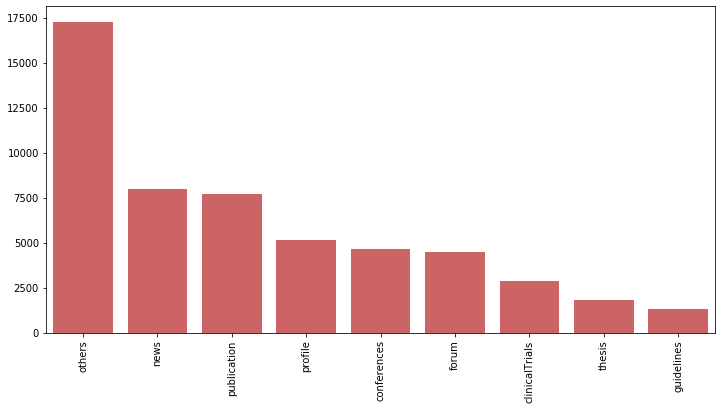

In [10]:
cnt_tag = df['Tag'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_tag.index, cnt_tag.values, alpha=0.8, color=color[3])
plt.xticks(rotation='vertical')
plt.show()

We can observe others contribute a lot. Now we will use wordcloud to find the most frequently occuring
words so we can know in which labels, what type of websites are frq occuring. wordcloud is a visualization tool.

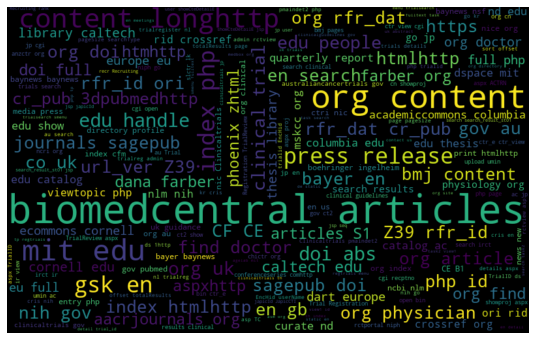

In [12]:
all_words=''.join([text for text in df['Url']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

We can different sizes of words. Larger size of words occur more. We can observe biomed, articles etc are occuring more. Lets create wordcloud each category of labels

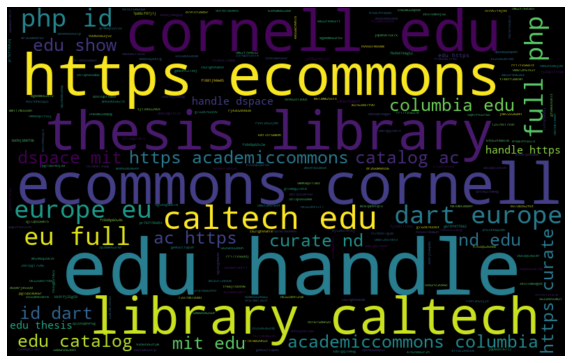

In [13]:
all_words = ' '.join([text for text in df[df['Tag'] == 'thesis']['Url']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

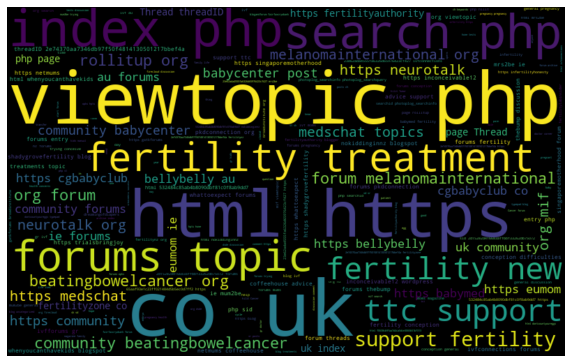

In [14]:
all_words = ' '.join([text for text in df[df['Tag'] == 'forum']['Url']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

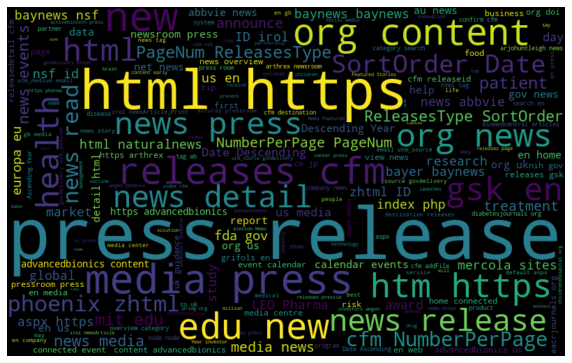

In [15]:
all_words = ' '.join([text for text in df[df['Tag'] == 'news']['Url']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

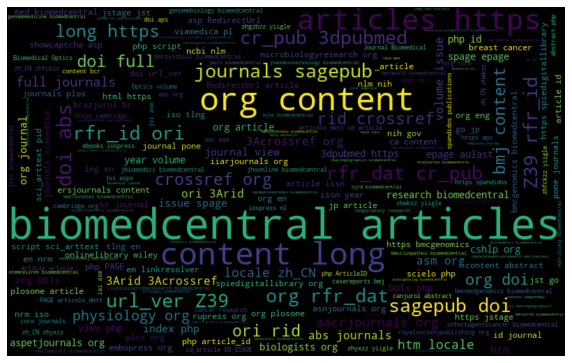

In [16]:
all_words = ' '.join([text for text in df[df['Tag'] == 'publication']['Url']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In this way, we find most frequently occuring words of all categories. 

Feature Extraction

Here we simply have domain and URL and these are neither numeric nor categorical variable as each URL is unique.

Here as from NLP, we extract information from text to create features and build a classifier.

The URLs in the dataset can be considered as a single string since the words in the URL have no spaces. Instead, there are 2 types of separators here '/' and '-'. We can replace these by spaces and we can get individual words this way

In [17]:
def clean_url(df):
    df["Url"] = df["Url"].str.replace("/", " ")
    df["Url"] = df["Url"].str.replace("-", " ")
    df["Url"] = df["Url"].str.replace("https:", "")
    df["Url"] = df["Url"].str.replace("http:", "")
    return df

In [18]:
df = clean_url(df)

In [19]:
df.head(5)

,Webpage_id,Domain,Url,Tag
0,1,www.fiercepharma.com,www.fiercepharma.com marketing tecfidera gilenya and aubagio s 3 way battle for ms share about to get more interesting,news
1,2,www.fiercepharma.com,www.fiercepharma.com pharma novo equipped to weather storm u s diabetes market ceo says,news
2,3,www.fiercepharma.com,www.fiercepharma.com pharma another exec departs troubled endo and time it s for another drugmaker,news
3,4,www.fiercepharma.com,www.fiercepharma.com pharma teva buy biosim specialist celltrion it wouldn t say no,news
4,5,www.fiercepharma.com,www.fiercepharma.com marketing actress marissa tomei partners allergan restasis to drive dry eye awareness,news


Now, that we have tokenised the words and done necessary cleaning. It is time to convert these to features.
    Bag of Words
    TFIDF (Term Frequency Inverse Document Frequency)
    Word Vectors

In [20]:
vec_bow = CountVectorizer(ngram_range=(1,4 ), min_df=400)
vec_bow.fit(df['Url'])
Url_bow = vec_bow.transform(df['Url'])

Model Building

This is a multi-class classification problem and the metric that we will use here is weighted F1-Score. As discussed in the multi-class module, weighted F1 score basically assigns weights proportional to the class frequency in the train set.


Train Test Split

Randomly spliting the dataset into train and test and checking performance will not be correct for this problem. Here's why:

Let's say we have a domain ecommons.cornell.edu. This is basically Cornell University's digital repository and predominantly contain thesis class. Now, if this domain (ecommons.cornell.edu) and class (thesis) combination are contained in both train and test. Just on the basis of domain I can predict the class to be thesis but this model would not be useful and would not generalise well on let's say new thesis by a different domain.

The Solution?

The train and test data split should done based on Domain-Tag combination, such that no 2 URLs for the same class and domain are kept in the train and test respectively because in that case domain can be directly mapped to the tag and that would be a leakage.


Model Validation

In [21]:
df["target_str"] = df["Domain"].astype(str) + '_' + df["Tag"].astype(str)
cvlist = list(GroupKFold(5).split(df, groups=df["target_str"]))

In [23]:
df["target_str"].head(2)

0    www.fiercepharma.com_news
1    www.fiercepharma.com_news
Name: target_str, dtype: object

In [24]:
cvlist

[(array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   35,    36,    37, ..., 53095, 53096, 53097])),
 (array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   92,    93,    94, ..., 52815, 52816, 52817])),
 (array([    0,     1,     2, ..., 53226, 53227, 53228]),
  array([   34,    39,    55, ..., 53213, 53215, 53216])),
 (array([    0,     1,     2, ..., 53213, 53215, 53216]),
  array([   38,    58,   146, ..., 53226, 53227, 53228])),
 (array([   34,    35,    36, ..., 53226, 53227, 53228]),
  array([    0,     1,     2, ..., 53025, 53026, 53027]))]

In [25]:
#converting tags to numericals
X = Url_bow

TAG_DICT = {"others":1, "news": 2, "publication":3, "profile": 4,
            "conferences": 5, "forum": 6, "clinicalTrials": 7,
            "thesis": 8, "guidelines": 9}

df['target'] = df.Tag.map(TAG_DICT)
y = df["target"].values

In [26]:
def cv_score(ml_model, df):
    i = 1
    cv_scores = []
    X = df
    
    # Custom Cross validation based on group KFold
    for df_index,test_index in cvlist:
        print('\n{} of Group kfold {}'.format(i,5))
        xtr,xvl = X[df_index],X[test_index]
        ytr,yvl = y[df_index],y[test_index]
            
        # Define model for fitting on the training set for each fold
        model = ml_model
        model.fit(xtr, ytr)
        pred_probs = model.predict_proba(xvl)
        label_preds = np.argmax(pred_probs, axis=1) + 1
        
        # Calculate scores for each fold and print
        score = f1_score(yvl, label_preds, average="weighted")
        sufix = ""
        msg = ""
        msg += "Weighted F1 Score: {}".format(score)
        print("{}".format(msg))
         
         # Save scores
        cv_scores.append(score)
        i+=1
    return cv_scores

Multinomial Naive Bayes

In [27]:
cv_score(MultinomialNB(alpha=.01), Url_bow)


1 of Group kfold 5
Weighted F1 Score: 0.5948608771452366

2 of Group kfold 5
Weighted F1 Score: 0.6335836331042835

3 of Group kfold 5
Weighted F1 Score: 0.5846446005822435

4 of Group kfold 5
Weighted F1 Score: 0.6727268353927283

5 of Group kfold 5
Weighted F1 Score: 0.6831258502247577


[0.5948608771452366,
 0.6335836331042835,
 0.5846446005822435,
 0.6727268353927283,
 0.6831258502247577]

In [28]:
# Word and character BOW on URLs
vec1 = CountVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = CountVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_bow = FeatureUnion([("char", vec1), ("word", vec2)])
vec_bow.fit(df['Url'])
Url_bow = vec_bow.transform(df['Url'])

In [29]:
cv_score(MultinomialNB(alpha=.01), Url_bow)


1 of Group kfold 5
Weighted F1 Score: 0.6762799783456942

2 of Group kfold 5
Weighted F1 Score: 0.6850809337506776

3 of Group kfold 5
Weighted F1 Score: 0.688822967439938

4 of Group kfold 5
Weighted F1 Score: 0.7216948488261381

5 of Group kfold 5
Weighted F1 Score: 0.704485742627938


[0.6762799783456942,
 0.6850809337506776,
 0.688822967439938,
 0.7216948488261381,
 0.704485742627938]

A significant improvement after changing bag of words

In [30]:
# Word and character TFIDF on URLs
vec1 = TfidfVectorizer(analyzer='char', ngram_range=(1, 5), min_df=500)
vec2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=400)
vec_tfidf = FeatureUnion([("char", vec1), ("word", vec2)])
vec_tfidf.fit(df['Url'])
Url_tfidf = vec_tfidf.transform(df['Url'])

In [31]:
nb = cv_score(MultinomialNB(alpha=.01), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.709831531814438

2 of Group kfold 5
Weighted F1 Score: 0.7028857528401553

3 of Group kfold 5
Weighted F1 Score: 0.7140138082517805

4 of Group kfold 5
Weighted F1 Score: 0.7474394007453241

5 of Group kfold 5
Weighted F1 Score: 0.7294679427204096


Logistic Regression

In [32]:
log_reg = cv_score(LogisticRegression(C=0.1,class_weight="balanced"), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.710486661136724

2 of Group kfold 5
Weighted F1 Score: 0.7476073359679621

3 of Group kfold 5
Weighted F1 Score: 0.7447959445222704

4 of Group kfold 5
Weighted F1 Score: 0.8078127129527103

5 of Group kfold 5
Weighted F1 Score: 0.8055615421382893


A significant improvement and better perforamnce. Lets check decision and random forest

In [33]:
dtree = cv_score(DecisionTreeClassifier(min_samples_leaf=25, min_samples_split=25), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.6031877259551395

2 of Group kfold 5
Weighted F1 Score: 0.6268793166157752

3 of Group kfold 5
Weighted F1 Score: 0.6237961282690911

4 of Group kfold 5
Weighted F1 Score: 0.6255937580459441

5 of Group kfold 5
Weighted F1 Score: 0.6530212598411355


In [34]:
rf_params = {'random_state': 0, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 50, 'n_jobs': -1}
rf = cv_score(RandomForestClassifier(**rf_params), Url_tfidf)


1 of Group kfold 5
Weighted F1 Score: 0.6606028719369305

2 of Group kfold 5
Weighted F1 Score: 0.6788263035907093

3 of Group kfold 5
Weighted F1 Score: 0.6459859779651346

4 of Group kfold 5
Weighted F1 Score: 0.7276128735459069

5 of Group kfold 5
Weighted F1 Score: 0.7319454872882054


Decision tree is bad, but random forest pereformed decently. 

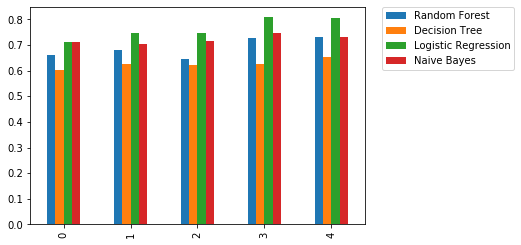

In [35]:
#comparing results
results_df = pd.DataFrame({'Random Forest':rf, 'Decision Tree': dtree, 'Logistic Regression': log_reg, 'Naive Bayes':nb})
results_df.plot(y=["Random Forest", "Decision Tree","Logistic Regression","Naive Bayes"], kind="bar")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Conclusions:

    Logistic Regression is getting the best performance.
    Interestingly Tree Based methods are performing badly.
    The scores are not very stable due to the large number of classes and few samples.